In [306]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

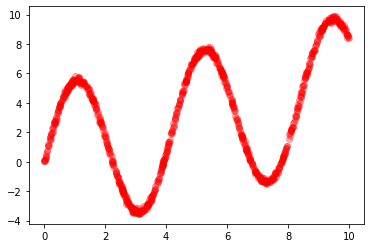

In [307]:
m = 1000
noise_std = 0.1
x_range = 10.0

eps = torch.randn(m, 1) * noise_std
X = torch.rand(m, 1) * x_range
y = 0.5 * X + 5.0 * torch.sin(1.5 * X) + eps


plt.plot(X.squeeze(), y, 'ro', alpha=0.3)
plt.show()

In [264]:
# A simple NN as described in PRML
class Net(nn.Module):
    def __init__(self, hidden_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)
            
        torch.nn.init.normal_(self.fc1.weight)
        torch.nn.init.normal_(self.fc2.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

Iteration 0, Loss: 43.903324127197266
Iteration 100, Loss: 8.904467582702637
Iteration 200, Loss: 7.929002285003662
Iteration 300, Loss: 5.623101711273193
Iteration 400, Loss: 0.3345519006252289
Iteration 500, Loss: 0.16389666497707367
Iteration 600, Loss: 0.18880398571491241
Iteration 700, Loss: 0.18546532094478607
Iteration 800, Loss: 0.08823097497224808
Iteration 900, Loss: 0.07995731383562088


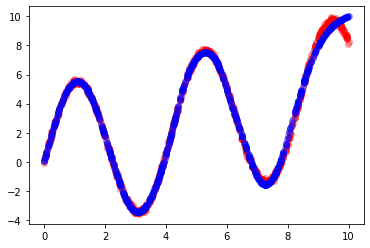

In [265]:
epochs = 1000
lr = 0.1

model = Net()
l2_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(epochs):
    y_hat = model(X)
    loss = l2_loss(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')
        
y_hat = model(X)
plt.plot(X.squeeze(), y,'ro', X.squeeze(), y_hat.squeeze().detach().cpu(), 'bo', alpha=0.3)
plt.show()

Iteration 0, Loss: 141.75979614257812
Iteration 100, Loss: 4.860604286193848
Iteration 200, Loss: 4.75350284576416
Iteration 300, Loss: 4.729090690612793
Iteration 400, Loss: 4.702401161193848
Iteration 500, Loss: 4.670895576477051
Iteration 600, Loss: 4.6294169425964355
Iteration 700, Loss: 4.581195831298828
Iteration 800, Loss: 4.506887912750244
Iteration 900, Loss: 4.450448036193848


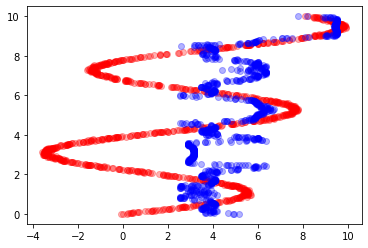

In [266]:
model = Net()
l2_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Again but now inversing the dynamics
for i in range(epochs):
    y_hat = model(y)
    loss = l2_loss(y_hat, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')
        
y_hat = model(y)
plt.plot(y, X.squeeze(),'ro', y_hat.squeeze().detach().cpu(), X.squeeze(), 'bo', alpha=0.3)
plt.show()

Due to multimodality of the data, we cannot get a good fit when using MSE loss it will regress to find good mean values for each of the inputs around 4. Or how PRML describes it, "We see that this leads to a very poor model for the highly non-Gaussian inverse problem".

> We therefore seek a general framework for modelling conditional probability distributions. This can be achieved by using a mixture model for p(t|x) in which both the mixing coefficients as well as the component densities are flexible functions of the input vector x, giving rise to the mixture density network.

In [311]:
class MDN(nn.Module):
    def __init__(self, hidden_dim, n_gaussians):
        super().__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(hidden_dim, n_gaussians)
        self.z_sigma = nn.Linear(hidden_dim, n_gaussians)
        self.z_mu = nn.Linear(hidden_dim, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu


def gaussian_distribution(y, mu, sigma):
    norm_term = 1.0 / np.sqrt(2.0 * np.pi)
    
    # |mu|= K copies of y - mu / sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    
    return (torch.exp(result) * torch.reciprocal(sigma)) * norm_term

Loss function:
$$E(\mathbf{w}) = - \sum_{n=1}^{N} \ln \left\{ \sum_{k=1}^{k} \pi_k(\mathbf{x}_n, \mathbf{w}) \mathcal{N} \left( t_n | \mu_k(\mathbf{x}_n, \mathbf{w}), \sigma_k^2(\mathbf{x}_n, \mathbf{w}) \right) \right\}
$$

In [312]:
epochs = 12000
lr = 0.001

model = MDN(hidden_dim=50, n_gaussians=8)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(epochs):
    pi, sigma, mu = model(y)
        
    loss = torch.sum(gaussian_distribution(X, mu, sigma) * pi, dim=1)
    loss = torch.mean(-torch.log(loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')

Iteration 0, Loss: 8.187727928161621
Iteration 1000, Loss: 1.6147420406341553
Iteration 2000, Loss: 1.365965723991394
Iteration 3000, Loss: -0.12670744955539703
Iteration 4000, Loss: -0.698192298412323
Iteration 5000, Loss: -0.7755858898162842
Iteration 6000, Loss: -0.8131919503211975
Iteration 7000, Loss: -0.8310821652412415
Iteration 8000, Loss: -0.8576422929763794
Iteration 9000, Loss: -0.8631715774536133
Iteration 10000, Loss: -0.8763270378112793
Iteration 11000, Loss: -0.8854507803916931


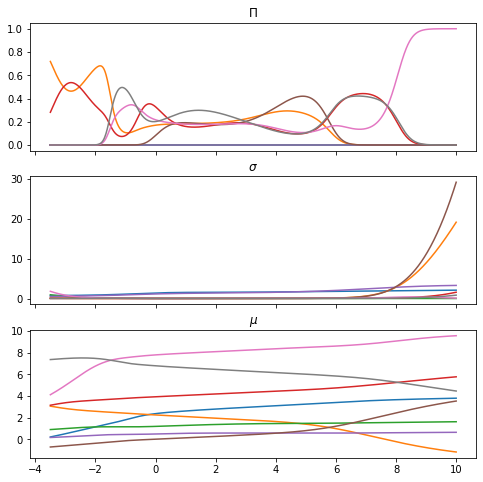

In [313]:
x_test = torch.linspace(-3.5, 10, 1000)
pi, sigma, mu = model(x_test.unsqueeze(-1))
pi, sigma, mu = pi.data.numpy(), sigma.data.numpy(), mu.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu)
ax3.set_title('$\mu$')
plt.show()

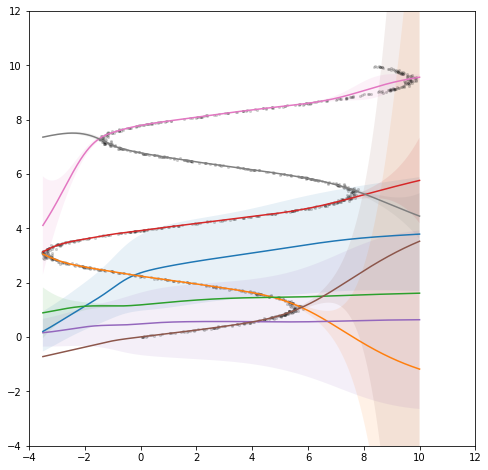

In [314]:
plt.figure(figsize=(8, 8), facecolor='white')

for mu_k, sigma_k in zip(mu.T, sigma.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)

plt.scatter(y, X, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-4, 12])
plt.ylim([-4, 12])
plt.show()

The Gumbel-max trick:
$$
    y = \underset{i \in \{1,...,K\}}{\mathrm{argmax}} \, x_i + z_i
$$
where $z_1 ... z_K$ are i.i.d. Gumbel(0, 1) random variates. It turns out that $y$ is distributed according to $\pi$.


In [317]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

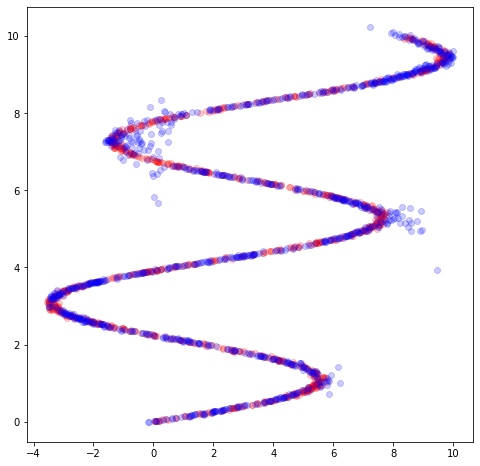

In [316]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))
plt.scatter(y, X, alpha=0.2, color='red')
plt.scatter(x_test_data, sampled, alpha=0.2, color='blue')
plt.show()